1. Function to sample images with a moving window
2. Function to and align stack images

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from skimage import io
import time
import tensorflow as tf
from sklearn.cluster import KMeans
import pickle
import imutils

In [200]:
# dictionary of minerals and their RGB values
MINERALS = {
    
    'quartz':([85,0,255],1),
    'plagioclase':([71,213,213],2),
    'orthoclase':([255,32,103],3),
    'muscovite':([251,119,255],4),
    'biotite':([255,170,0],5),
    'clay minerals':([255,85,0],6),
    'calcite':([],7),
    'dolomite':([],8),
    
}

def sample_img(df, ppl, xpl, labels, width = 200, height = 200, inc = 75, status = False):
    '''
    Function samples image and stores RGB and greyscale color channels in dataframe.
    Assumed ppl and xpl images are the same size.
    ''' 
    width = width
    height = height
    inc = inc

    topleft = [0,0]
    botright = [width,height]
    # increment for x and y to change topleft and botright values
    xinc = inc
    yinc = inc
    # number of x slices to take and number of y slices to take
    xi = (ppl.size[0]-width)//inc
    yi = (ppl.size[1]-height)//inc
    
    # dictionary to hold orientations and their pairs
    orientations = {'leftright': Image.FLIP_LEFT_RIGHT,
                   'topbottom': Image.FLIP_TOP_BOTTOM}
    
    print(f'{yi} rows and {xi} columns to slice.')
    print(f'Total observations: {yi*xi*12}')
    
    # iterate through each sliding window along the height of the image
    start = time.time()
    for y in np.arange(yi):
        for x in np.arange(xi):
            
            # select orientation of image
            for orientation in [0, 1, 2]:
                if orientation == 0:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright)
                    xpl_slice = xpl.crop(topleft+botright)
                    labels_slice = labels.crop(topleft+botright)
                elif orientation == 1:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                    xpl_slice = xpl.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                    labels_slice = labels.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                else:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)
                    xpl_slice = xpl.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)
                    labels_slice = labels.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)

                # for each slice, rotate 90 degrees up to 270 to get 4 orientations of each slice
                for rotation in [0, 90, 180, 270]:
                    ppl_slice = ppl_slice.rotate(rotation)
                    xpl_slice = xpl_slice.rotate(rotation)
                    labels_slice = labels_slice.rotate(rotation)
                    # split RGB color channels
                    ppl_red, ppl_green, ppl_blue = ppl_slice.split()
                    xpl_red, xpl_green, xpl_blue = xpl_slice.split()
                    # put all colors into dataframe row
                    df_slice = pd.DataFrame([[np.array(ppl_red), np.array(ppl_green), np.array(ppl_blue), 
                                              np.array(xpl_red), np.array(xpl_green), np.array(xpl_blue),
                                              np.array(labels_slice), rotation, topleft]], columns = columns)
                    #append to main dataframe
                    df = df.append(df_slice, ignore_index = True)
            
            # shift sliding window
            topleft[0] += 100
            botright[0] += 100
            
        if status == True and y % 10 == 0:
            end = time.time()
            print(f'Runtime for row {y}/{yi} is {round(end - start,2)} seconds for {len(df)} samples')
            
        # reset sample box to left side of image
        topleft[0] = 0
        botright[0] = width
        # shift sample box down 100 pixels
        topleft[1] += 100
        botright[1] += 100
        
    
    return df

def show_img(df, rows):
    '''
    Function to display a slice from the dataframe. Rows is either a single value,
    or a list of integers you want to get the samples at those rows for.
    '''
    for i in rows:
        plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        plt.imshow(np.dstack((df['r_ppl'][i], df['g_ppl'][i], df['b_ppl'][i])))
        plt.subplot(1,3,2)
        plt.imshow(np.dstack((df['r_xpl'][i], df['g_xpl'][i], df['b_xpl'][i])))
        plt.subplot(1,3,3)
        plt.imshow(df['labels'][i])
    return

def img_quant(img, n_colors=7, plot=False, min_dict=MINERALS):
    '''Transforms RGB image into a discretized array by clustering similar RGB values'''
    if min_dict == None:
        original = np.array(img)

        # reshape original into one long array with RGB values in lists
        X = original.reshape(-1,3)
        # fit the KMeans clusters
        kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(X)

        #assign each pixel to its proper cluster color based on the k-means labels
        segmented_img = kmeans.cluster_centers_[kmeans.labels_]

        # get a list of the unique colors (classes)
        # and re-label the image with discretized values
        # axis=0 so it will consider each list as a unique value
        unique_classes, relabeled_img = np.unique(segmented_img, axis=0, return_inverse=True)

        # re-shape to original image dimensions
        segmented_img = segmented_img.reshape(original.shape).astype(np.uint8)
        relabeled_img = relabeled_img.reshape((original.shape[0:2])).astype(np.uint8)
        relabeled_img = Image.fromarray(relabeled_img)
    
    '''Use this if you want to change colors based on set pixel values
    instead of clustering'''
    
    if min_dict != None:
        original = np.array(img)
        length, width = original.shape[0:2]
        original = original.reshape(-1,3)

        segmented_img = original.copy()

        # empty list to keep track of which minerals are present in the image
        unique_classes = []

        for mineral in min_dict.keys():  
            # make all pixels of one color a new color
            try:
                segmented_img[(original[:,0]==min_dict[mineral][0][0]) & (original[:,1]==min_dict[mineral][0][1]) & (original[:,2]==min_dict[mineral][0][2])] = min_dict[mineral][1]
                unique_classes.append(min_dict[mineral][1])
            except:
                print(f'{mineral} may not be present')

            # assign final to be only one column of values
                continue

        segmented_img = [x if x in unique_classes else 0 for x in segmented_img[:,0]]
        segmented_img = np.array(segmented_img).reshape(length, width).astype(np.uint8)
        relabeled_img = Image.fromarray(segmented_img)

        original = original.reshape(length,width,3)
    
    # plot if true
    if plot == True:
        plt.figure(figsize=(10,20))
        plt.subplot(1,2,1)
        plt.imshow(original)
        plt.title('Original image')
        
        plt.subplot(1,2,2)
        plt.imshow(segmented_img)
        plt.title(f'{len(unique_classes)} color clusters')
        
    return relabeled_img

def align_images(df, ppl_img, xpl_img, labels_img, threshold=10, confidence=0.99):
    '''Takes in a dataframe of corresponding points from each image and aligns them using
    a homography matrix. Images just need to be opened with Image.open()'''

    # get pts from df
    ppl_pts = np.array(df['ppl'].tolist())
    xpl_pts = np.array(df['xpl'].tolist())
    labels_pts = np.array(df['labels'].tolist())

    # compute homography matrix between two sets of matched points
    (xpl_H, xpl_mask) = cv2.findHomography(ppl_pts, xpl_pts, cv2.RANSAC, ransacReprojThreshold=threshold, confidence=confidence)
    (labels_H, labels_mask) = cv2.findHomography(ppl_pts, labels_pts, cv2.RANSAC, ransacReprojThreshold=threshold, confidence=confidence)
    
    # use the homography matrix to align the images to the ppl img
    (xpl_h, xpl_w) = ppl_img.shape[:2]
    xpl_aligned = cv2.warpPerspective(xpl_img, xpl_H, (xpl_w,xpl_h))
    
    (labels_h, labels_w) = ppl_img.shape[:2]
    labels_aligned = cv2.warpPerspective(labels_img, labels_H, (labels_w,labels_h))
    

    # resize both the aligned and template images so we can easily 
    # visualize them on the screen
    ppl_aligned = imutils.resize(ppl_img, width=700)
    xpl_aligned = imutils.resize(xpl_aligned, width=700)
    labels_aligned = imutils.resize(labels_aligned, width=700)
    
    plt.imshow(labels_aligned)
    
    ppl = imutils.resize(ppl_img, width=700)
    xpl = imutils.resize(xpl_img, width=700)
    labels = imutils.resize(labels_img, width=700)

    # side-by-side comparison of the output aligned image and the template
    stacked = np.hstack([ppl_aligned, xpl_aligned, labels_aligned])

    # second image alignment visualization will be overlaying the
    # aligned image on the template to get an idea of how good
    # the image alignment is

    template = ppl_aligned.copy()
    xpl_overlay = xpl_aligned.copy()
    labels_overlay = labels_aligned.copy()
    
    print(xpl_overlay.shape)
    print(labels_overlay.shape)
    print(labels.shape)
    
    
    cv2.addWeighted(template, 0.5, xpl_overlay, 0.5, 0, xpl_overlay)
    cv2.addWeighted(template, 0.5, labels_overlay, 0.5, 0, labels_overlay)
    
#     print(labels.shape)
#     print(template.shape)
    
    cv2.addWeighted(template, 0.5, xpl, 0.5, 0, xpl)
    cv2.addWeighted(template, 0.5, labels, 0.5, 0, labels)
    
    # stack overlay imgs next to each other
    overlays_stacked = np.hstack([xpl, labels])
    aligned_overlays_stacked = np.hstack([xpl_overlay, labels_overlay])

    # show the two output inmage alignment visualizations
    plt.figure(figsize=(30,20))

    plt.subplot(3,1,1)
    plt.title('Side-by-side images')
    plt.imshow(stacked)
    
    plt.subplot(3,1,2)
    plt.title('Un-aligned overlayed images')
    plt.imshow(overlays_stacked)

    plt.subplot(3,1,3)
    plt.title('Aligned overlayed images')
    plt.imshow(aligned_overlays_stacked)

    plt.tight_layout()
    
    return overlays_stacked

def find_dimensions(df):
    
    '''Function to find the [height and width of labeled image'''
    
    width = df['labels'][1][0]-df['labels'][0][0]
    height = df['labels'][1][1]-df['labels'][0][1]
            
    return height, width

def resize_imgs(df, ppl, xpl, labels, plot=False):
    
    ''' Load images as cv2.imread(). This will then find the matching crop
    dimensions using find_dimensions and return the new resized and cropped images'''
    
    # check if input images are np.ndarray type or Image type
    if type(ppl) == np.ndarray:
        ppl = Image.fromarray(ppl)
        xpl = Image.fromarray(xpl)
        labels = Image.fromarray(labels)


    # crop images
    ppl_crop = ppl.crop(df['ppl'][0]+df['ppl'][1])
    xpl_crop = xpl.crop(df['xpl'][0]+df['xpl'][1])
    labels_crop = labels.crop(df['labels'][0]+df['labels'][1])

    # get height and width that you need to resize all images to
    height, width = find_dimensions(df)
    # resize images
    # do not resize labels because we want to preserve pixel resolution
    ppl_crop = ppl_crop.resize((width, height),Image.NEAREST)
    xpl_crop = xpl_crop.resize((width, height),Image.NEAREST)
    
    if plot == True:
        plt.figure(figsize=(15, 20))
        plt.subplot(2,3,1)
        plt.title('Original PPL')
        plt.imshow(ppl)
        plt.subplot(2,3,2)
        plt.title('Original XPL')
        plt.imshow(xpl)
        plt.subplot(2,3,3)
        plt.title('Original Labels')
        plt.imshow(labels)
        # second row cropped images
        plt.subplot(2,3,4)
        plt.title('Cropped PPL')
        plt.imshow(ppl_crop)
        plt.subplot(2,3,5)
        plt.title('Cropped XPL')
        plt.imshow(xpl_crop)
        plt.subplot(2,3,6)
        plt.title('Cropped Labels')
        plt.imshow(labels_crop)
        plt.tight_layout()
    return ppl_crop, xpl_crop, labels_crop

In [3]:
# kquant library functions
def show_color_counts(img, figsize=(20,20), columns=5, color='BGR', limit=0, top=None):
    ''' Input an image in the format of a np.array and return
    subplots of each pixel color plotted with the RGB color value and number
    of pixels in the image that are that color.'''
    
    try:
        # reshape img pixels to be unrolled into one single column
        img = img.reshape((-1, 3))
    except:
        print('input image must be converted to np.array')
        img = np.array(img)
        img = img.reshape((-1, 3))
    
    # get the unique pixel values and their counts
    value, counts = np.unique(img, axis=0, return_counts=True)
    # create a list containing pairs of pixel values and their counts
    data = list(zip(value, counts))
    # sort list in reverse order from high to low counts
    data = sorted(data, reverse=True, key=lambda x: x[1])
    
    if top == None:
        # assign the number of plots to make to be equal to the number of unique pixels
        num_plots = len(data)
        # calculate how many subplot rows
        if len(data) % columns != 0:
            rows = int((len(data) // columns) + 1)
        else:
            rows = int(len(data) // columns)
    else:
        # assign the number of plots to make to be equal to top
        num_plots = top
        if top % columns != 0:
            rows = int(int(top // columns) + 1)
        else:
            rows = int(top // columns)
    
    # plot figure
    plt.figure(figsize=figsize)
    
    # iterate through each unique color
    for i in range(num_plots):
        plt.subplot(rows, columns, i+1)
        # turn off axes since it is 1 px by 1 px
        plt.axis('off')
        # calculate percentage of image that each pixel color makes up
        prc = round((data[i][1]/len(img))*100,2)
        if color == 'BGR':
            
            plt.title(f'RGB: {data[i][0][::-1]}\nTotal num pixels: {data[i][1]}\n{prc}% of total pixels')
            # Reverse assuming image is in BGR color format
            plt.imshow([[list(data[i][0])[::-1]]])
        elif color == 'RGB':
            plt.title(f'RGB: {data[i][0]}\nTotal num pixels: {data[i][1]}\n{prc}% of total pixels')
            # Reverse assuming image is in BGR color format
            plt.imshow([[list(data[i][0])]])
        else:
            plt.title('Color not RGB')
        
    plt.tight_layout()
        
        
    return

# Load in test image

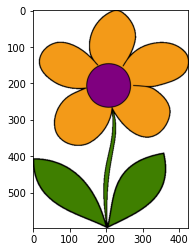

In [29]:
test = Image.open('Images/cipart.png').convert('RGB')
plt.imshow(test)

### Color Quantization to find most common pixel colors

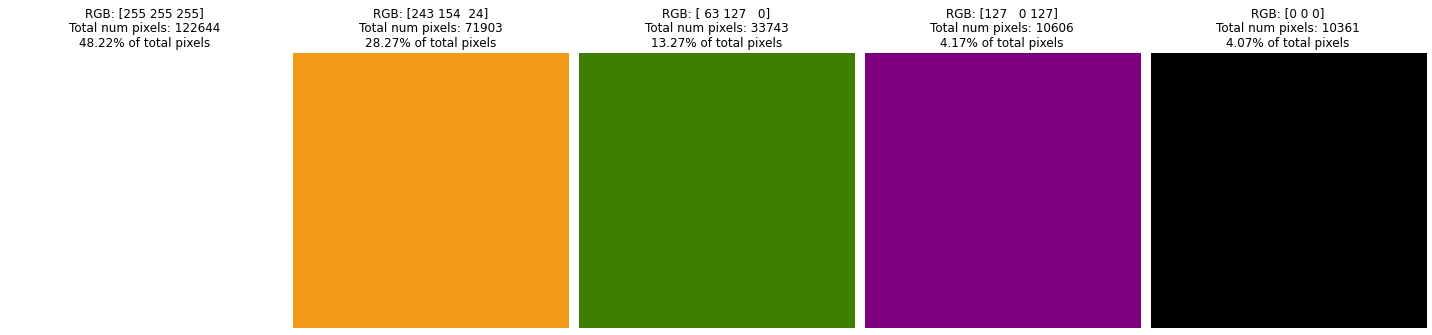

In [32]:
show_color_counts(np.array(test), color='RGB', top=5)

# Test cropping method

(3415, 6357)


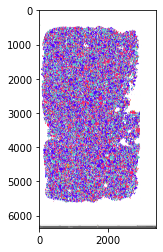

In [218]:
test_path = 'Images/EDF17-1.png'
# load image
pil_img = Image.open(test_path).convert('RGB')
# print image dimensions
print(pil_img.size)
plt.imshow(pil_img)

In [219]:
# use img quant to classify pixels
labels = img_quant(pil_img)

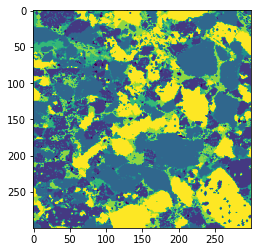

In [220]:
slice = labels.crop([1000,1000]+[1300,1300])
plt.imshow(slice)

In [246]:
# look at slice to ensure colors have been classified
test_array = np.array(slice)
print(test_array.shape)

(300, 300)


In [247]:
resized = Image.fromarray(test_array)

In [248]:
downsampled = resized.resize((100,100), Image.NEAREST)

In [249]:
unique, counts = np.unique(np.array(downsampled), return_counts=True)

frequencies = np.asarray((unique, counts))

print(frequencies)

[[   0    1    2    3    4    5    6]
 [ 115 2276 2834  602  391 1162 2620]]


# Resize Images before alignment
* run resize.py to get the resize_pts.pkl

In [186]:
df = pd.read_pickle('resize_pts.pkl')
df.head()

ppl           xpl        labels
0    [271, 165]    [245, 179]    [301, 643]
1  [2965, 5255]  [2984, 5245]  [2860, 5220]

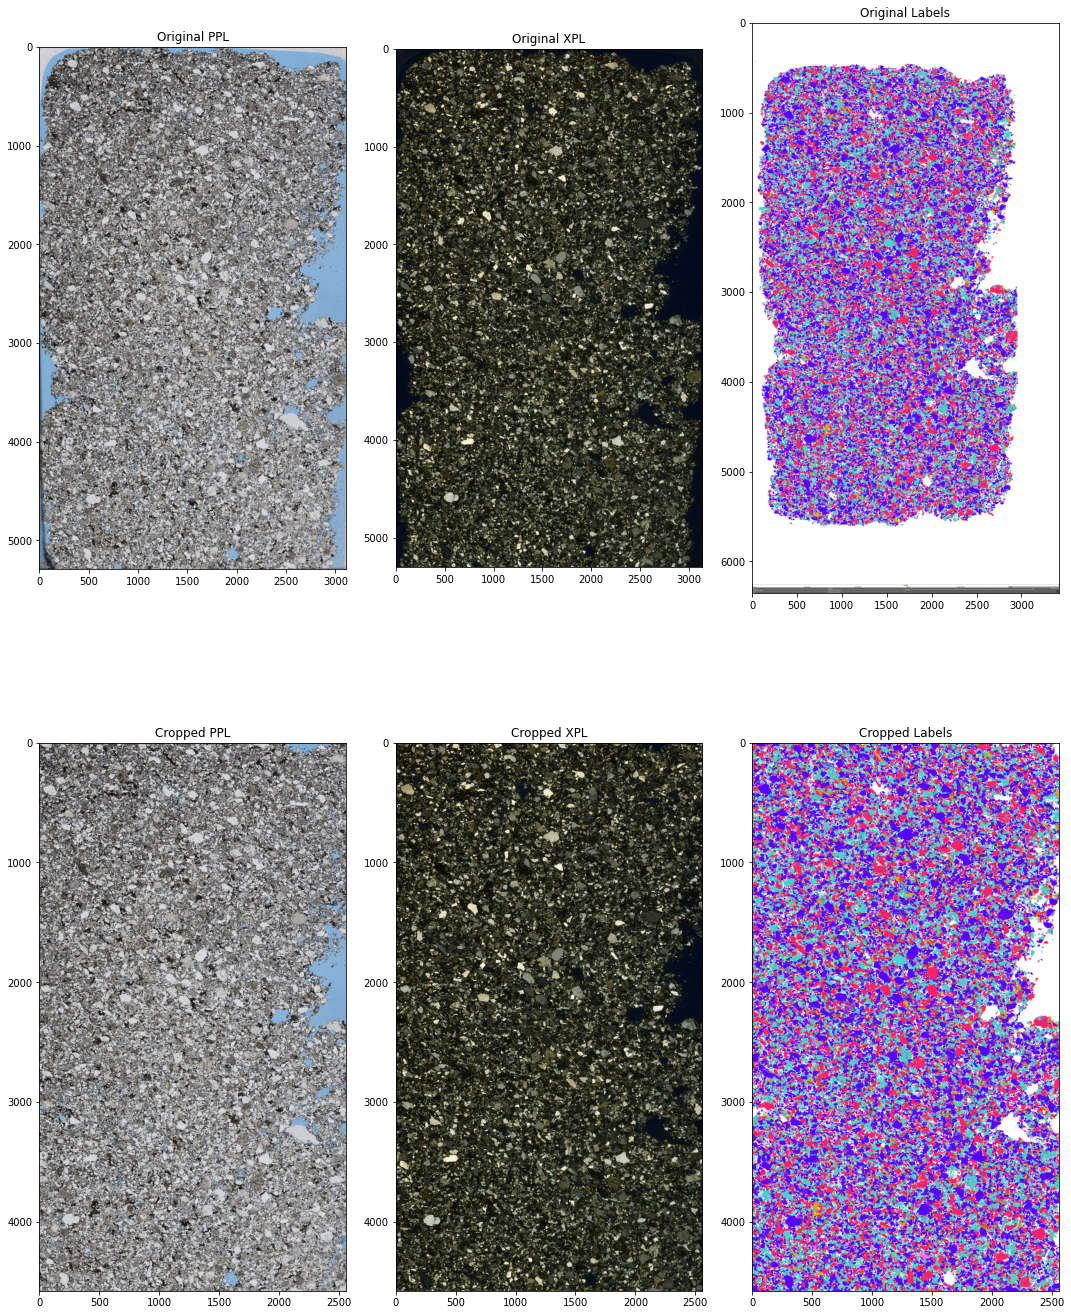

In [187]:
ppl = Image.open('Images/EDF-17-1-PPL.jpg')
xpl = Image.open('Images/EDF-17-1-CPL.jpg')
labels = Image.open('Images/EDF17-1.png')


df = pd.read_pickle('resize_pts.pkl')

ppl, xpl, labels = resize_imgs(df, ppl, xpl, labels, plot=True)

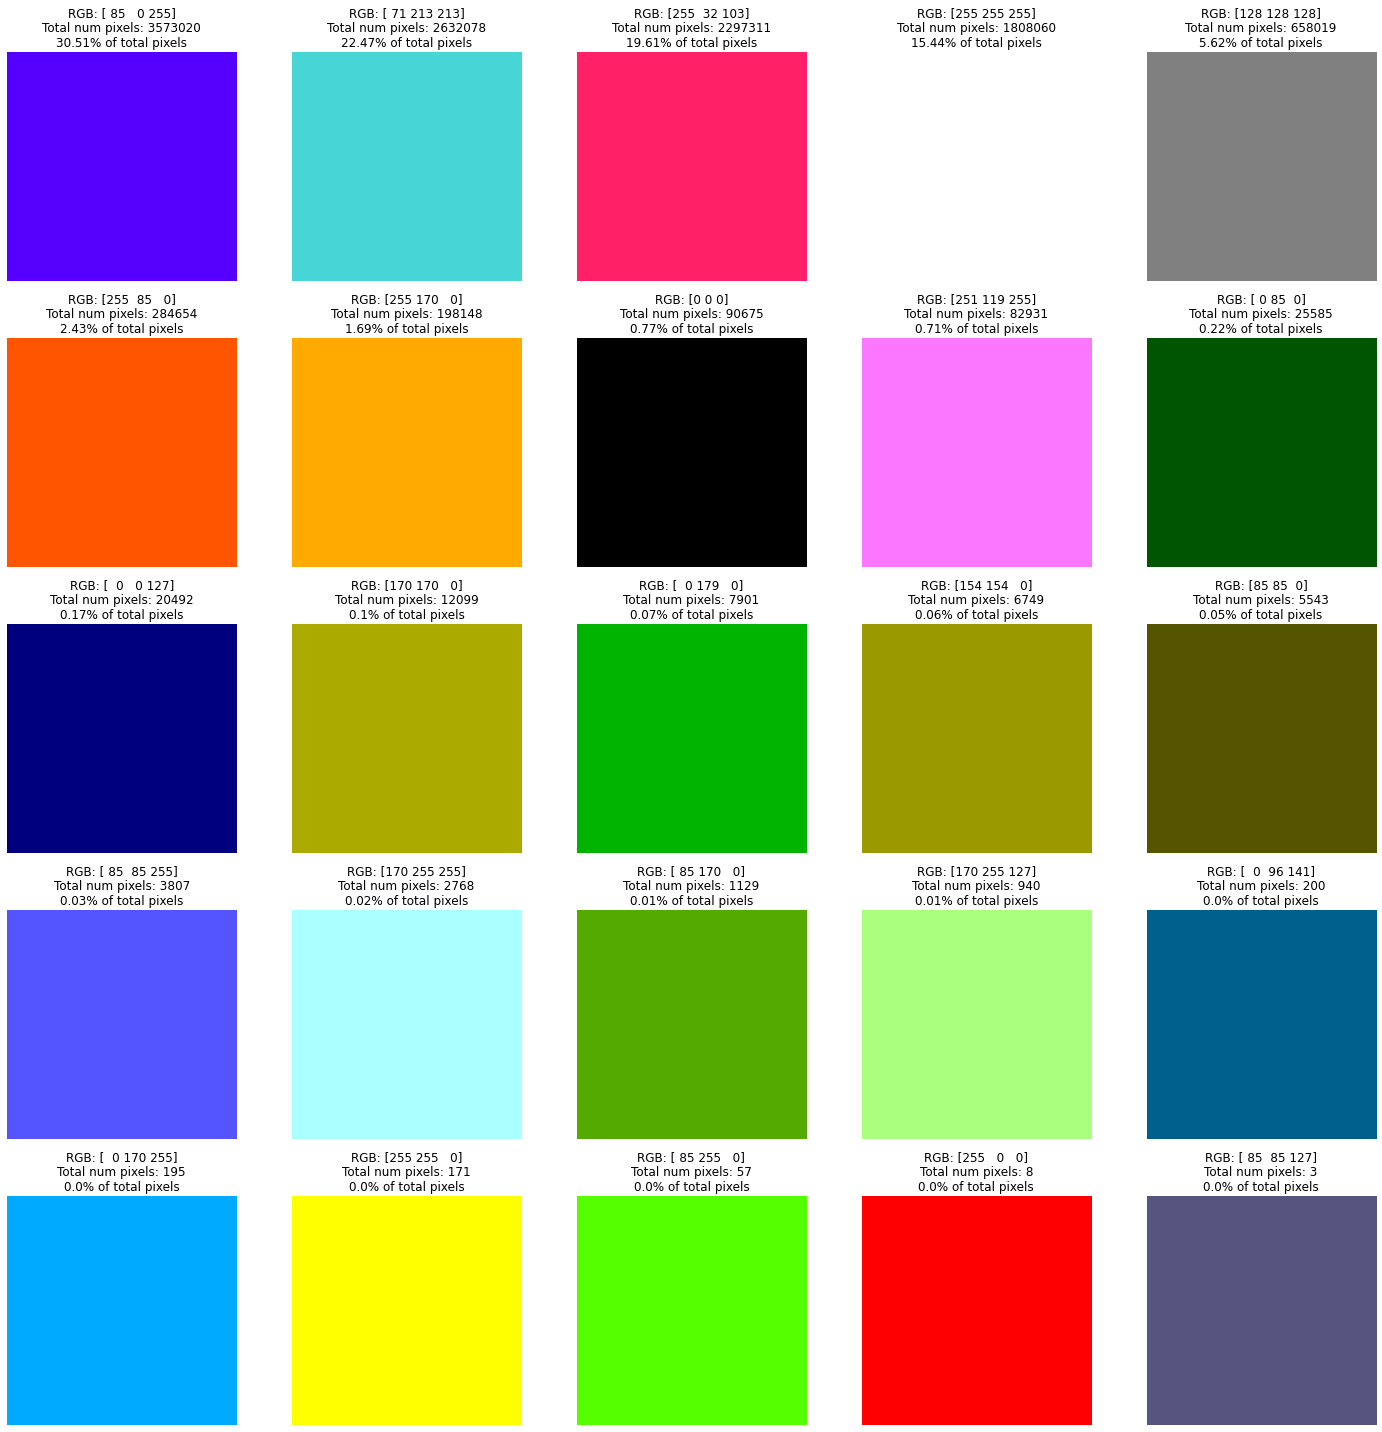

In [8]:
# look at unique colors in labeled image
show_color_counts(np.array(labels), color='RGB')

# Align images 
* run tiepoints.py to get the homography points
* run align_images(homography_pts, ppl_img, xpl_img, labels_img)

# Image quantization
* run labels = img_quant(labels)

calcite may not be present
dolomite may not be present


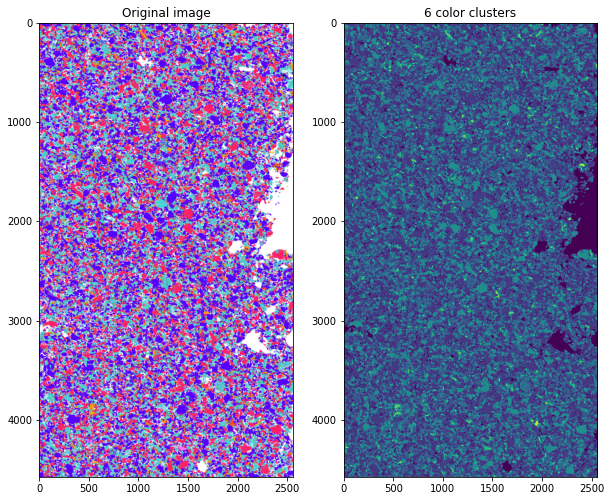

In [188]:
# classify colors in the image
labels = img_quant(labels, plot=True, min_dict=MINERALS)

[[      0       1       2       3       4       5       6]
 [2644401 3573020 2632078 2297311   82931  198148  284654]]


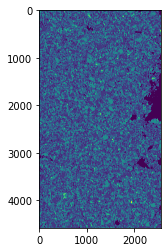

In [189]:
# plot the new classified image
plt.imshow(labels)
unique, counts = np.unique(np.array(labels), return_counts=True)

frequencies = np.asarray((unique, counts))

print(frequencies)

# Sample data

In [191]:
# make sure all images are the same size
print(labels.size)
print(ppl.size)
print(xpl.size)

(2559, 4577)
(2559, 4577)
(2559, 4577)


In [193]:
# create dataframe to hold the image slices
# columns will be red, blue, green color channels and greyscale value.
columns = ['r_ppl','g_ppl','b_ppl', 'r_xpl','g_xpl','b_xpl','labels','rotation','topleft']
df = pd.DataFrame(columns = columns)

In [194]:
data = sample_img(df, ppl, xpl, labels, status=True)

58 rows and 31 columns to slice.
Total observations: 21576
Runtime for row 0/58 is 1.32 seconds for 372 samples
Runtime for row 10/58 is 16.77 seconds for 4092 samples
Runtime for row 20/58 is 43.67 seconds for 7812 samples
Runtime for row 30/58 is 79.59 seconds for 11532 samples
Runtime for row 40/58 is 122.01 seconds for 15252 samples
Runtime for row 50/58 is 175.41 seconds for 18972 samples


In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   r_ppl     21576 non-null  object
 1   g_ppl     21576 non-null  object
 2   b_ppl     21576 non-null  object
 3   r_xpl     21576 non-null  object
 4   g_xpl     21576 non-null  object
 5   b_xpl     21576 non-null  object
 6   labels    21576 non-null  object
 7   rotation  21576 non-null  object
 8   topleft   21576 non-null  object
dtypes: object(9)
memory usage: 1.5+ MB


In [196]:
# check unique values
unique, counts = np.unique(np.array(data.labels[100]), return_counts=True)

frequencies = np.asarray((unique, counts))

print(frequencies)

[[    0     1     2     3     4     5     6]
 [ 8007 15218  9452  5847   111   426   939]]


# View some sample observations

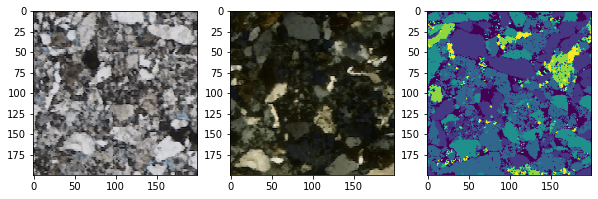

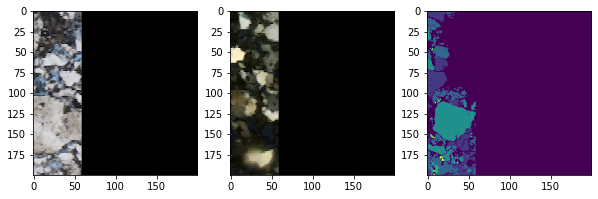

In [201]:
show_img(data, [200, 300])

# Align images

In [ ]:
# get pts from df
# ppl_pts = np.array(df['ppl'].tolist())
# labels_pts = np.array(df['labels'].tolist())

ppl_pts = np.array([[866, 580], [874, 1275], [200, 1529], [82, 180], [508, 338],
                   [535, 714], [38, 1069], [449, 1315], [914, 53], [981, 1612]])
labels_pts = np.array([[2482, 2065], [2527, 3938], [716, 4644], [352, 1007], [1511, 1426],
                      [1592, 2433], [266, 3408], [1382, 4056], [2597, 644], [2727, 4841]])

# load and view sample image
ppl_img = cv2.imread('Images/ppltest.jpg')
labels_img = cv2.imread('Images/EDF17-1.png')


plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(ppl_img)
# plot dots
plt.scatter(ppl_pts[:,0], ppl_pts[:,1], color='r')
plt.title('Template Image')

plt.subplot(1,2,2)
plt.imshow(labels_img)
# plot red dot
plt.scatter(labels_pts[:,0], labels_pts[:,1],color='cyan')
plt.title('TIMA')

# compute homography matrix between two sets of matched points
(labels_H, labels_mask) = cv2.findHomography(ppl_pts, labels_pts, cv2.RANSAC, ransacReprojThreshold=10, confidence=0.99)

# use the homography matrix to align the images to the ppl img
(labels_h, labels_w) = ppl_img.shape[:2]
labels_aligned = cv2.warpPerspective(labels_img, labels_H, (labels_w,labels_h))



In [ ]:
plt.imshow(labels_aligned)

In [ ]:
plt.imshow(ppl_img)

In [ ]:
output = align_images(df, ppl, xpl, labels)

In [ ]:
df = sample_img(df, ppl, xpl, labels, status=True)

In [ ]:
show_img(df, 20)

In [ ]:
df.info()

In [ ]:
# show all orientations for a single slice
plt.figure(figsize=(8,8))
for i in np.arange(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.dstack((df['r_xpl'][i], df['g_xpl'][i], df['b_xpl'][i])))
    plt.title(df['rotation'][i])